<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork32585014-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Clustering based Course Recommender System**


Previously, we have generated user profile vectors based on course ratings and genres.

A user profile vector may look like a row vector in the following matrix, for example, we can see the Database column for user2 has a value 1 which means user2 is very interesting in courses related to the databases. With the user profile vectors generated, we can also easily compute the similarity among users based on their shared interests.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_3/images/userprofiles.png)


Furthermore, we could perform clustering algorithms such as K-means or DBSCAN to group users with similar learning interests. For example, in the below user clusters, we have user clusters whom have learned courses related to machine learning, cloud computing, databases, and web development, etc.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_3/images/userprofiles_clustering.png)


For each user group, we can come up with a list of popular courses. For example, for the machine learning user cluster/learning group, we can count the most frequently enrolled courses, which are very likely to be the most popular and good machine learning courses because they are enrolled by many users who are interested in machine learning.

If we know a user belongs to the machine learning group, we may recommend the most enrolled courses to them and it is very likely the user will be interested in them.


Next in this lab, you will be implementing some clustering-based recommender system algorithms.


## Objectives


After completing this lab you will be able to:


*   Perform k-means clustering on the original user profile feature vectors
*   Apply PCA (Principle Component Analysis ) on user profile feature vectors to reduce dimensions
*   Perform k-means clustering on the PCA transformed main components
*   Generate course recommendations based on other group members' enrollment history


***


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
# Also set a random state for reproducibility
rs = 123

### Load the user profile dataset


Let's first load the original user profile feature vectors:


In [4]:
# Defining the URL of the CSV file containing user profiles
user_profile_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_profile.csv"
# Using pandas' read_csv function to read the CSV file from the specified URL into a DataFrame
user_profile_df = pd.read_csv(user_profile_url)
# Displaying the first few rows of the DataFrame to inspect its contents
user_profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [5]:
# Displaying the shape of the DataFrame (rows, columns)
user_profile_df.shape

(33901, 15)

we can then list the feature names, they are the user interested topics (course genres):


In [6]:
# Extracting feature names by excluding the first column (assumed to be 'user')
feature_names = list(user_profile_df.columns[1:])
feature_names

['Database',
 'Python',
 'CloudComputing',
 'DataAnalysis',
 'Containers',
 'MachineLearning',
 'ComputerVision',
 'DataScience',
 'BigData',
 'Chatbot',
 'R',
 'BackendDev',
 'FrontendDev',
 'Blockchain']

As we can see from the user profile dataset, we have about 33K unique users with interests in areas like `Database`, `Python`, `CloudComputing`, etc. Then, let's check the  summary statistics for each feature.


In [7]:
# Generating descriptive statistics (like mean, std, min, max) for each feature
user_profile_df.iloc[:,1:].describe().T

,count,mean,std,min,25%,50%,75%,max
Database,33901.0,5.518569,7.611941,0.0,0.0,3.0,9.0,63.0
Python,33901.0,3.493791,4.227254,0.0,0.0,3.0,6.0,18.0
CloudComputing,33901.0,2.307100,3.841858,0.0,0.0,0.0,3.0,38.0
DataAnalysis,33901.0,3.624701,4.760135,0.0,0.0,3.0,6.0,48.0
Containers,33901.0,0.998938,2.351764,0.0,0.0,0.0,0.0,15.0
MachineLearning,33901.0,3.048022,4.624004,0.0,0.0,0.0,3.0,39.0
ComputerVision,33901.0,0.001770,0.072846,0.0,0.0,0.0,0.0,3.0
DataScience,33901.0,5.087343,5.230697,0.0,0.0,3.0,9.0,32.0
BigData,33901.0,4.750450,7.216228,0.0,0.0,2.0,6.0,54.0
Chatbot,33901.0,0.462995,1.055186,0.0,0.0,0.0,0.0,6.0


The original user profile feature vector is not normalized, which may cause issues when we perform clustering and Principal component analysis (PCA), therefor we standardize the data.


In [9]:
# Calculating the mean of each feature before standardizing
user_profile_df[feature_names].mean() 

Database           5.518569
Python             3.493791
CloudComputing     2.307100
DataAnalysis       3.624701
Containers         0.998938
MachineLearning    3.048022
ComputerVision     0.001770
DataScience        5.087343
BigData            4.750450
Chatbot            0.462995
R                  1.017433
BackendDev         2.269461
FrontendDev        0.315802
Blockchain         0.986844
dtype: float64

In [10]:
# Use StandardScaler to standardize features to have mean 0 and standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
# Printing the mean and standard deviation after scaling to verify
print("mean\n {} \n and standard deviation\n{} ".format(user_profile_df[feature_names].mean(),user_profile_df[feature_names].std()))

mean
 Database          -3.353495e-17
Python            -5.700942e-17
CloudComputing    -3.521170e-17
DataAnalysis      -7.671120e-17
Containers         3.353495e-18
MachineLearning    3.688845e-17
ComputerVision    -1.509073e-17
DataScience       -1.676748e-17
BigData            6.706990e-17
Chatbot           -6.874665e-17
R                  4.233788e-17
BackendDev         1.383317e-17
FrontendDev        5.051202e-17
Blockchain        -5.281755e-17
dtype: float64 
 and standard deviation
Database           1.000015
Python             1.000015
CloudComputing     1.000015
DataAnalysis       1.000015
Containers         1.000015
MachineLearning    1.000015
ComputerVision     1.000015
DataScience        1.000015
BigData            1.000015
Chatbot            1.000015
R                  1.000015
BackendDev         1.000015
FrontendDev        1.000015
Blockchain         1.000015
dtype: float64 


In [11]:
# Generating descriptive statistics post-scaling
user_profile_df.iloc[:,1:].describe()

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
count,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04,3.390100e+04
mean,-3.353495e-17,-5.700942e-17,-3.521170e-17,-7.671120e-17,3.353495e-18,3.688845e-17,-1.509073e-17,-1.676748e-17,6.706990e-17,-6.874665e-17,4.233788e-17,1.383317e-17,5.051202e-17,-5.281755e-17
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
25%,-7.249991e-01,-8.265040e-01,-6.005256e-01,-7.614816e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-9.726080e-01,-6.583107e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
50%,-3.308757e-01,-1.168130e-01,-6.005256e-01,-1.312380e-01,-4.247674e-01,-6.591835e-01,-2.429612e-02,-3.990622e-01,-3.811535e-01,-4.387873e-01,-4.343370e-01,-5.264730e-01,-2.316212e-01,-5.059295e-01
75%,4.573712e-01,5.928781e-01,1.803581e-01,4.990056e-01,-4.247674e-01,-1.038556e-02,-2.429612e-02,7.480294e-01,1.731609e-01,-4.387873e-01,-4.343370e-01,1.694715e-01,-2.316212e-01,5.194189e-01
max,7.551593e+00,3.431642e+00,9.290667e+00,9.322416e+00,5.953517e+00,7.775190e+00,4.115884e+01,5.145214e+00,6.824934e+00,5.247500e+00,7.249771e+00,1.200053e+01,1.076995e+01,5.646161e+00


The normalized user profile features are:


In [12]:
# Separating features from the 'user' column
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
features

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,6.106474,2.485388,0.961242,8.272010,0.850889,6.477594,-0.024296,4.571668,5.023412,1.456642,7.249771,7.360899,6.369323,2.570116
1,4.529980,-0.353377,0.440653,5.120792,-0.424767,2.368540,-0.024296,2.851031,2.667576,-0.438787,2.127032,0.865416,-0.231621,0.519419
2,2.427988,1.066006,4.084776,4.280467,-0.424767,5.828796,-0.024296,3.233395,1.281790,1.456642,5.542191,5.505047,2.702132,2.570116
3,-0.462250,-0.826504,-0.600526,-0.341319,-0.424767,-0.659184,-0.024296,-0.972608,-0.381153,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
4,0.063248,-0.826504,-0.600526,0.078843,-0.424767,-0.659184,-0.024296,-0.972608,0.173161,-0.438787,0.419453,-0.526473,-0.231621,-0.505930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33896,-0.330876,-0.116813,0.180358,0.499006,-0.424767,-0.659184,-0.024296,0.174484,-0.658311,-0.438787,2.127032,0.865416,-0.231621,1.032093
33897,-0.724999,-0.826504,-0.079936,-0.761482,-0.424767,-0.659184,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930
33898,-0.330876,0.592878,0.961242,-0.761482,-0.424767,2.368540,-0.024296,0.748029,-0.658311,-0.438787,0.846348,-0.526473,-0.231621,-0.505930
33899,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.226652,-0.024296,-0.972608,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.505930


we can also save the user ids for later recommendation tasks:


In [13]:
# Extracting user IDs into a separate DataFrame
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user'] # make it a df
user_ids

,user
0,2
1,4
2,5
3,7
4,8
...,...
33896,2102054
33897,2102356
33898,2102680
33899,2102983


### Perform K-means clustering algorithm on the user profile feature vectors


With the user profile dataset ready, you need to use the `KMeans` class provided by scikit-learn library to perform clustering on the user profile feature vectors.


For `KMeans` algorithm, one important hyperparameter is the number of clusters `n_cluster`, and a good way to find the optimized `n_cluster` is using to grid search a list of candidates and find the one with the best or optimized clustering evaluation metrics such as minimal `sum of squared distance`:


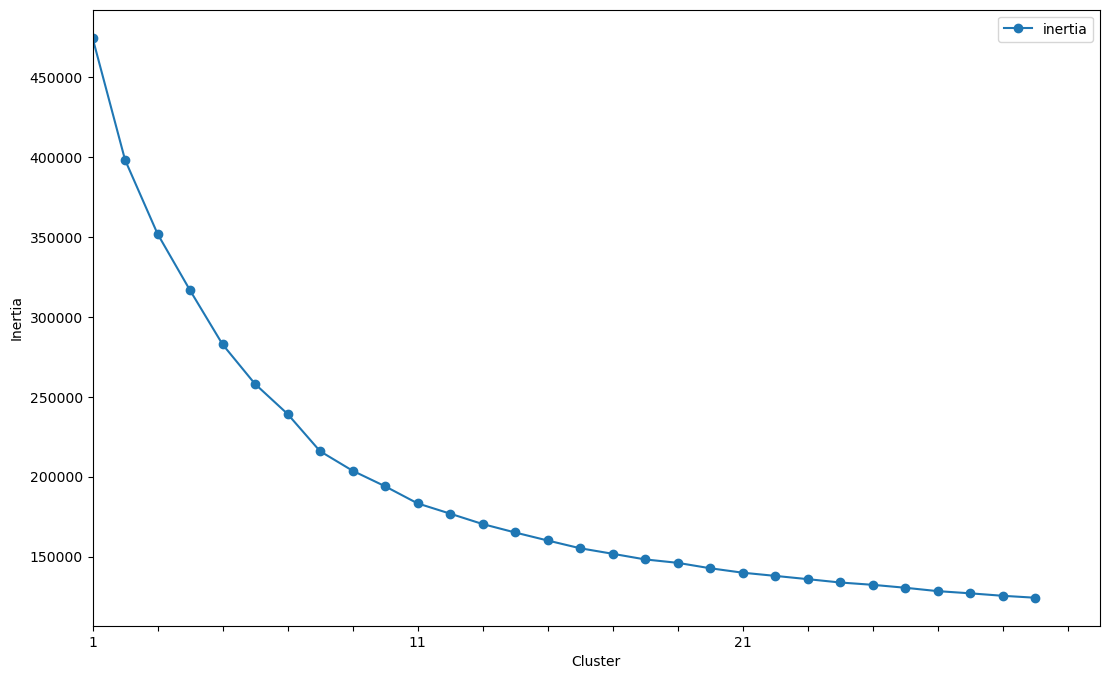

In [14]:
# Find an optimized number of neighors k from a candidate list such as list_k = list(range(1, 30))

from sklearn.cluster import KMeans
km_list = list()

# Iterating through the candidate number of clusters
for clust in range(1,31): # Test 30 clusters 
    km = KMeans(n_clusters=clust, random_state=rs) # Initiate the model
    km = km.fit(features)
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))
    
# Preparing data for the elbow plot by concatenating the inertia values
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

# Plotting the inertia values against the number of clusters to visualize the elbow
ax = plot_data.plot(marker='o',ls='-', figsize=(13,8))
ax.set_xticks(range(0,31,2))
ax.set_xlim(0,31)
ax.set(xlabel='Cluster', ylabel='Inertia');

From the elbow plot, you should visualy identify the point where the metric starting to be flatten, which indicates the optimized number of clusters.


Once you have identified the best number of clusters, you can apply `KMeans()` again to generate cluster label for all users.


In [15]:
# Choosing K = 20 based on the elbow plot as a good fit
km = KMeans(n_clusters=20, random_state=rs) # Initiate the model
km = km.fit(features)
km

KMeans(n_clusters=20, random_state=123)

In [16]:
# Extracting cluster labels assigned to each user
cluster_labels = km.labels_
cluster_labels

array([18, 17, 18, ...,  2,  6,  6])

In [17]:
# Creating a copy of the original DataFrame and adding a 'Cluster' column
clustered_df = user_profile_df.copy()
clustered_df['Cluster'] = cluster_labels
clustered_df.sample(3)

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain,Cluster
5101,511174,-0.724999,-0.826504,-0.600526,-0.761482,-0.424767,-0.659184,-0.024296,-0.590244,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.50593,6
12910,890534,0.063248,0.592878,0.180358,0.499006,-0.424767,-0.010386,-0.024296,1.895121,-0.242575,-0.438787,0.846348,0.169472,-0.231621,-0.50593,11
22225,1266946,-0.724999,1.302569,-0.600526,0.499006,-0.424767,-0.010386,-0.024296,0.748029,-0.658311,-0.438787,-0.434337,-0.526473,-0.231621,-0.50593,16


The cluster labels you generated is a list of integers indicating cluster indices. You may use the following utility method to combine the cluster labels and user ids to a dataframe, so that you know which cluster a user belongs:


In [18]:
def combine_cluster_labels(user_ids, labels):
    """
    Combines user IDs with their corresponding cluster labels.

    Parameters:
    - user_ids (DataFrame): DataFrame containing user identifiers.
    - labels (array-like): Array of cluster labels.

    Returns:
    - cluster_df (DataFrame): Merged DataFrame with 'user' and 'cluster' columns.
    """
    labels_df = pd.DataFrame(labels)
    cluster_df = pd.merge(user_ids, labels_df, left_index=True, right_index=True)
    cluster_df.columns = ['user', 'cluster']
    return cluster_df

In [19]:
# Combining user IDs with their cluster labels
combine_cluster_labels(user_ids,cluster_labels)

,user,cluster
0,2,18
1,4,17
2,5,18
3,7,6
4,8,6
...,...,...
33896,2102054,12
33897,2102356,6
33898,2102680,2
33899,2102983,6


Now, each user finds its own cluster or we can say we have created many clusters of learning communities. Learners within each community share very similar learning interests.


### Apply PCA on user profile feature vectors to reduce dimensions


In the previous step, we applied `KMeans` on the original user profile feature vectors which have 14 original features (the course genres).


In [20]:
# Re-defining features and user_ids for clarity
features = user_profile_df.loc[:, user_profile_df.columns != 'user']
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'user']
feature_names = list(user_profile_df.columns[1:])

In [21]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 14 features for each user profile.


If we plot a covariance matrix of the user profile feature vectors with 14 features, we can observe that some features are actually correlated:


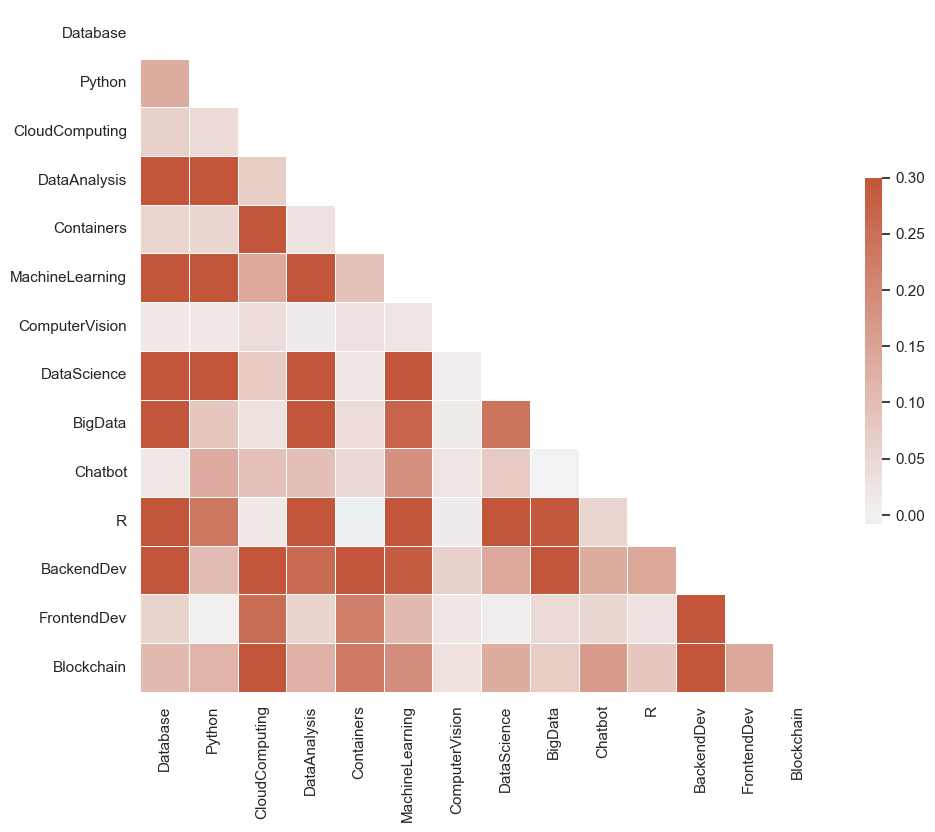

In [22]:
sns.set_theme(style="white")

# Compute the covariance matrix as a measure of correlation
corr = features.cov()

# Generate a mask for the upper triangle to avoid redundancy in the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure with a specified size
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap for better visualization
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

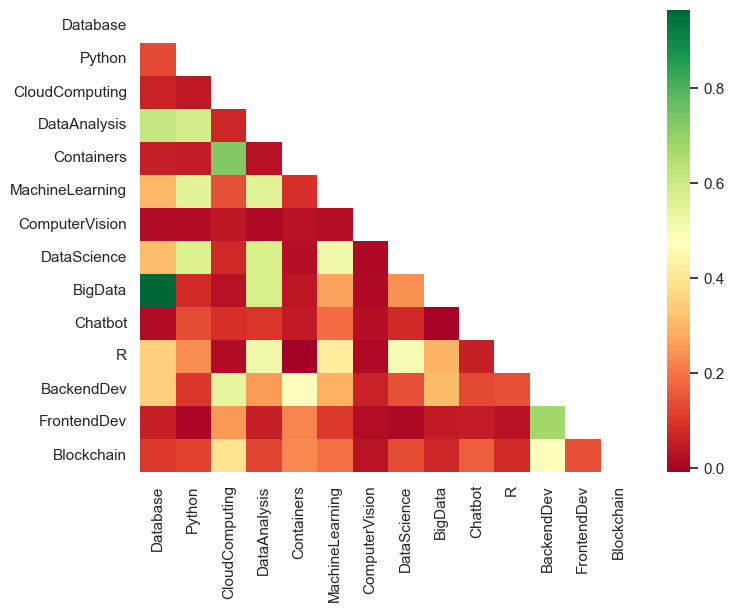

In [23]:
# Compute the Pearson correlation matrix
corrmat = features.corr()
# Mask for upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

plt.figure(figsize=(8,6))
# Plot heatmap without annotations, using "RdYlGn" colormap and applying the mask
g = sns.heatmap(corrmat, annot=False,cmap="RdYlGn",mask = mask)

For example, the feature `MachineLearning` and the feature `DataScience` are correlated. Such covariances among features may indicate that we can apply PCA to find its main components (eigenvectors with max eigenvalues on the covariance matrix).

If we only keep the independent main components, then we can reduce the dimensions of our user profile feature vectors.


Now let's apply the `PCA()` provided by  `scikit-learn` to find the main components in user profile feature vectors and see if we can reduce its dimensions by only keeping the main components.


Note that when calling the  `PCA()` class, there is also an import argument called `n_components` which indicates how many components you want to keep in the PCA result. One way to find an optimized `n_components` is to do a grid search on a list of argument candidates (such as `range(1, 15)`) and calculate the ratio of the accumulated variance for each candidate.

If the accumulated variances ratio of a candidate `n_components` is larger than a threshold, e.g., 90%, then we can say the transformed `n_components` could explain about 90% of variances of the original data variance and can be considered as an optimized components size.


In [24]:
# - For a list of candidate `n_components` arguments such as 1 to 14, find out the minimal `n` that can explain accumulated 90% variances of previous data
# - In the fitted PCA() model, you can find explained_variance_ratio_ and use the sum() function to add them to get the accumulated variance ratio

from sklearn.decomposition import PCA
pca_list = list()
feature_weight_list = list()

# Iterating through the candidate number of principal components

for n in range(1, 15):
    
    # Initialize and fit PCA with n components
    PCAmod = PCA(n_components=n)
    PCAmod.fit(features)
    
    # Store the model and the cumulative variance explained
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()})) # pending series to list
    
    # Calculate and store feature importances based on explained variance
    weights = PCAmod.explained_variance_ratio_.reshape(-1,1)/PCAmod.explained_variance_ratio_.sum()
    overall_contribution = np.abs(PCAmod.components_)*weights
    abs_feature_values = overall_contribution.sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': features.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))

# Creating a DataFrame from the list of PCA results
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df


,model,var
n,,
1,PCA(n_components=1),0.287568
2,PCA(n_components=2),0.463093
3,PCA(n_components=3),0.576134
4,PCA(n_components=4),0.648747
5,PCA(n_components=5),0.719488
6,PCA(n_components=6),0.78821
7,PCA(n_components=7),0.842956
8,PCA(n_components=8),0.894445
9,PCA(n_components=9),0.92727


In [25]:
# Creating a DataFrame for feature importances across different numbers of components
features_importance_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_importance_df.head()

features,BackendDev,BigData,Blockchain,Chatbot,CloudComputing,ComputerVision,Containers,DataAnalysis,DataScience,Database,FrontendDev,MachineLearning,Python,R
n,,,,,,,,,,,,,,
1,0.088497,0.095053,0.054786,0.028111,0.052312,0.007183,0.043639,0.119681,0.096857,0.103455,0.041011,0.102603,0.081675,0.085137
2,0.103284,0.076431,0.067295,0.025308,0.086821,0.009063,0.078407,0.100615,0.083992,0.081170,0.064910,0.076303,0.070378,0.076023
3,0.093271,0.096166,0.062978,0.035349,0.076708,0.008184,0.067475,0.083615,0.087131,0.097654,0.058662,0.080404,0.085507,0.066897
4,0.090126,0.087393,0.060778,0.050436,0.079921,0.028019,0.074346,0.077060,0.083229,0.088582,0.064213,0.074181,0.079556,0.062160
5,0.089562,0.082881,0.057353,0.050936,0.081688,0.049511,0.077447,0.071520,0.077815,0.083929,0.075193,0.070411,0.073772,0.057982


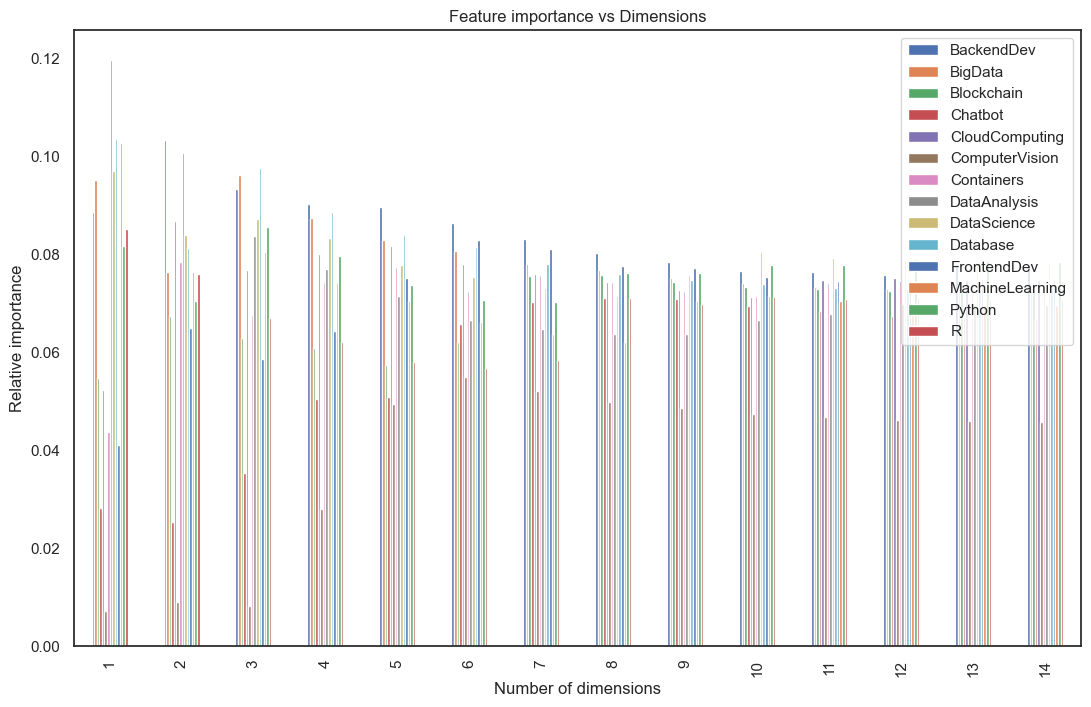

In [26]:
# Plotting feature importance across different numbers of principal components
ax = features_importance_df.plot(kind='bar', figsize=(13,8))
ax.legend(loc='upper right')
ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

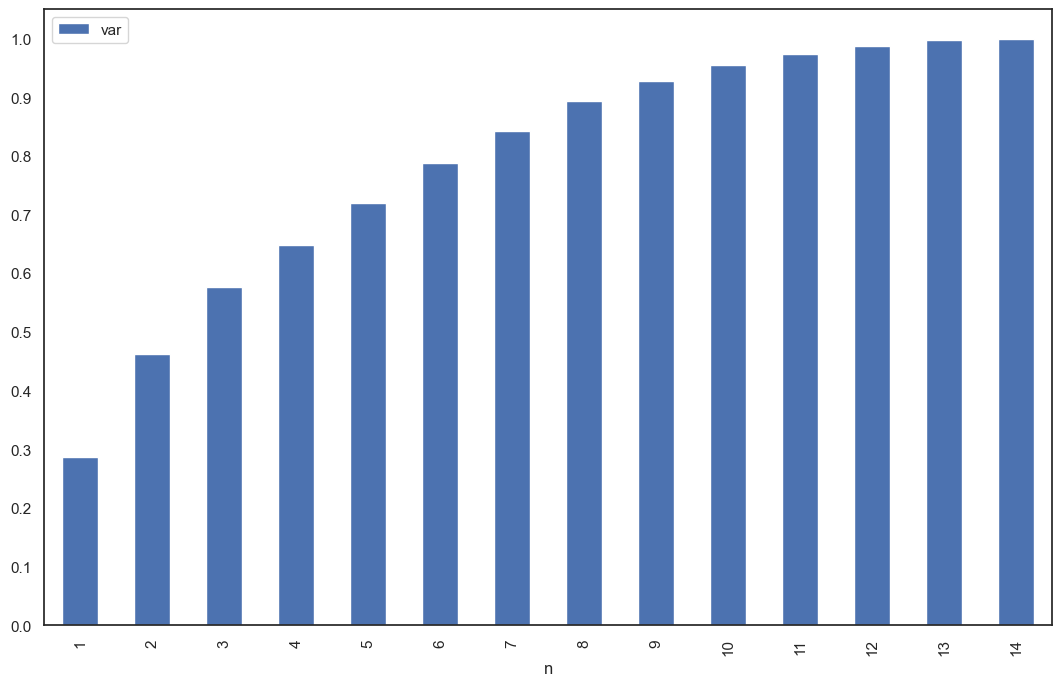

In [27]:
# Plotting cumulative variance explained by the principal components
pca_df.plot(kind = 'bar', figsize=(13,8));
plt.yticks(np.arange(0,1.1, 0.1));

Once you found the optimized `n_component` argument value, you can apply PCA on the user profile feature vectors and reduce the  14 features into  `n_component` features.


*Perform PCA to transform original user profile features*


In [28]:
# We found out that that 9 components will capture +90% of variance
# - For a list of candidate `n_components` arguments such as 1 to 14, find out the minimal `n` that can explain accumulated 90% variances of previous data
# - In the fitted PCA() model, you can find explained_variance_ratio_ and use the sum() function to add them to get the accumulated variance ratio
# - Merge the user ids and transformed features into a new dataframe

# Based on the PCA analysis, selecting 9 components to capture over 90% variance
model = PCA(n_components=9)            
reduced_df = model.fit_transform(features)  # Fit and transform X_train_S                         
reduced_df = pd.DataFrame(reduced_df)
reduced_df.insert(0,'user_ids',user_ids.user)
reduced_df


,user_ids,0,1,2,3,4,5,6,7,8
0,2,17.772494,0.200681,1.730609,2.567359,-3.825814,2.707154,0.681042,2.312613,0.868272
1,4,7.145199,-2.847481,2.358636,-0.576654,0.398803,-0.134533,0.549769,0.469033,0.033405
2,5,11.363270,1.873619,-1.522077,1.076144,-1.711688,0.883212,1.677582,2.937669,2.097639
3,7,-1.834033,-0.277462,0.564905,0.053470,-0.064440,0.165757,0.030956,0.039519,0.210887
4,8,-1.049125,-0.684767,1.072765,0.006371,-0.005695,0.118686,0.118559,0.559292,0.186379
...,...,...,...,...,...,...,...,...,...,...
33896,2102054,0.633824,0.108815,-0.388871,-0.122665,-0.098364,0.358333,1.752049,1.486542,-0.523600
33897,2102356,-2.095339,0.135058,0.244727,-0.088185,0.025081,0.183641,0.046413,0.191709,0.260437
33898,2102680,0.625943,-0.547167,-1.692824,-0.630589,0.166632,0.676244,-0.055100,0.582091,1.703193
33899,2102983,-2.036832,-0.153534,0.162852,0.082651,-0.126419,0.255109,0.072496,0.113750,0.622900


### Perform k-means clustering on the PCA transformed feature vectors


Now, you have the PCA  components of the original profile vectors. You can perform k-means on them again:


*Perform K-means on the PCA transformed features*


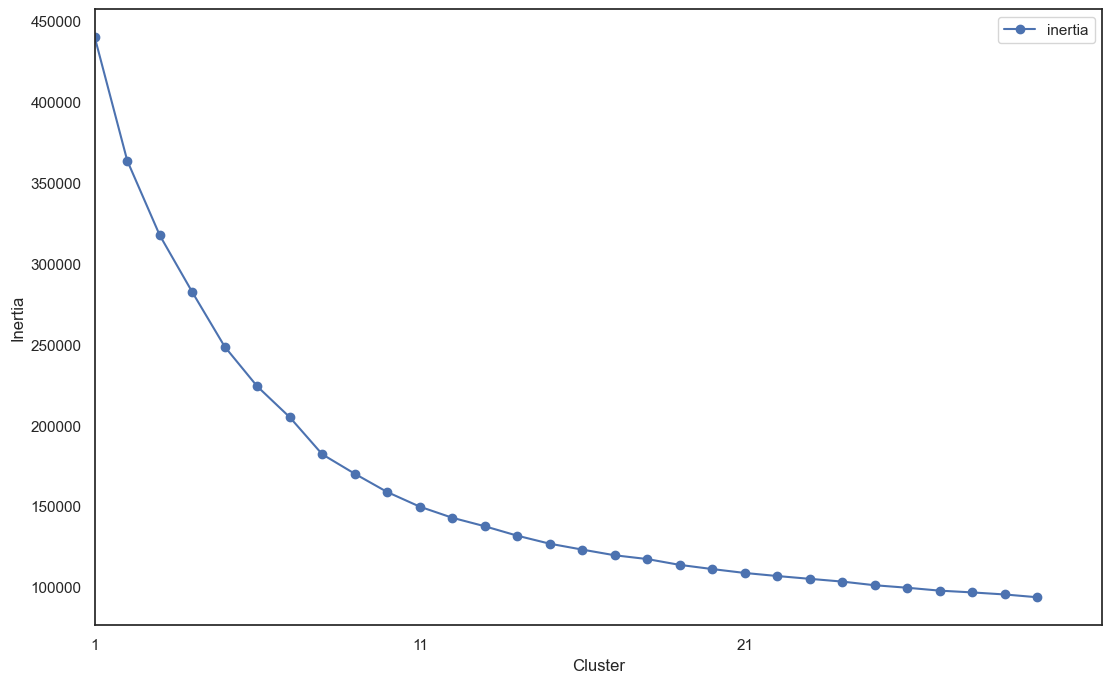

In [29]:
# Separating PCA features and user IDs
pca_features = reduced_df.drop('user_ids',axis = 1)
km_list = list()

# Iterating through the candidate number of clusters for PCA-reduced data
for clust in range(1,31): # Test 30 clusters 
    km = KMeans(n_clusters=clust, random_state=rs) # Initiate the model
    km = km.fit(pca_features)
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))
    
# Preparing data for the elbow plot
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

# Plotting the inertia values to visualize the elbow
ax = plot_data.plot(marker='o',ls='-', figsize=(13,8))
ax.set_xticks(range(0,31,2))
ax.set_xlim(0,31)
ax.set(xlabel='Cluster', ylabel='Inertia');

In [30]:
# Applying KMeans with the chosen number of clusters (e.g., K=8 based on elbow plot)
km = KMeans(n_clusters=8, random_state=rs) # Initiate the model
km = km.fit(pca_features)

# Combining user IDs with their new cluster labels
cluster_df = combine_cluster_labels(user_ids,km.labels_)
cluster_df

,user,cluster
0,2,6
1,4,6
2,5,6
3,7,1
4,8,1
...,...,...
33896,2102054,5
33897,2102356,1
33898,2102680,5
33899,2102983,1


Great, now all users find their learning interest groups, either based on their original or the PCA transformed user profile features.


When a user is in a group or a community, it is very likely that the user will be interested in the courses enrolled by other members within the same group.


### Generate course recommendations based on the popular courses in the same cluster


The Intuition of clustering-based course recommendation is very simple and can be illustrated via the following example:


Suppose a user has joined a machine learning group (via clustering algorithm). In the group, he/she finds that the top-3 courses enrolled by all other group members are `Machine Learning for Everyone`, `Machine Learning with Python`, `Machine Learning with Scikit-learn`. Since the user has already completed the `Machine Learning for Everyone` earlier, he/she decides to trust the group members' choices and enroll in other two unselected courses `Machine Learning with Python` and `Machine Learning with Scikit-learn`.


In summary, the clustering-based recommender system first groups all users based on their profiles, and maintains a popular courses list for each group.

For any group member who needs course recommendations, the algorithm recommends the unselected courses from the popular course lists.


Next, suppose we have a set of test users, and we want to recommend new courses to them using a clustering-based recommender system:


In [31]:
# Defining the URL for the test users' content data
test_user_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
# Loading the test users' data and selecting relevant columns
test_users_df = pd.read_csv(test_user_url)[['user', 'item']]
test_users_df.head()

,user,item
0,1502801,RP0105EN
1,1609720,CNSC02EN
2,1347188,CO0301EN
3,755067,ML0103EN
4,538595,BD0115EN


In [32]:
# Confirming that some users have enrolled in multiple courses
print(len(test_users_df))
print(len(test_users_df.user.unique()))

9402
1000


The test users dataset has only two columns, the user id and the enrolled course id.


For each user, let's find its cluster label using the k-means results you have performed in previous steps, assuming it is named `cluster_df`.


You can assign the cluster label to all test users via merging the clustering labels (`cluster_df`:):


In [33]:
# Merging test users' data with their cluster assignments
test_users_labelled = pd.merge(test_users_df, cluster_df, left_on='user', right_on='user')
test_users_labelled

,user,item,cluster
0,1502801,RP0105EN,4
1,1609720,CNSC02EN,5
2,1347188,CO0301EN,3
3,755067,ML0103EN,4
4,538595,BD0115EN,4
...,...,...,...
9397,1385217,EE0101EN,4
9398,1864644,DA0101EN,5
9399,435858,TMP0105EN,1
9400,1888188,DB0101EN,3


The merged the test dataset may look like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_3/images/test_users_label.png)


From the above dataframe, we know each user's enrolled courses and its cluster index.

If we use a `groupby`  and `sum` aggregation, we can get the enrollments count for each course in each group, like the following code snippet:


In [34]:
# Relating user enrollments to their respective clusters
courses_cluster = test_users_labelled[['item', 'cluster']] # Relating users items to their clusters 
courses_cluster['count'] = [1] * len(courses_cluster)

# Aggregating enrollments by cluster and item
courses_cluster = courses_cluster.groupby(['cluster','item']).agg(enrollments = ('count','sum')).reset_index()
courses_cluster.cluster.unique()

array([0, 1, 2, 3, 4, 5, 6])

In [35]:
# Filtering courses with at least 10 enrollments and sorting them
popular_courses_per_cluster = (courses_cluster[courses_cluster.enrollments >= 10]
                       .sort_values(by = 'enrollments',ascending = False))
popular_courses_per_cluster

,cluster,item,enrollments
475,5,PY0101EN,234
445,5,DS0101EN,178
332,4,BD0111EN,162
438,5,DA0101EN,160
331,4,BD0101EN,147
...,...,...,...
481,5,SC0101EN,10
465,5,ML0120EN,10
163,1,SC0103EN,10
262,3,CB0103EN,10


In [36]:
# For each user, find its cluster label
users_clusters = test_users_labelled[['user','cluster']]
users_clusters = users_clusters.drop_duplicates(subset=None, keep='first', ignore_index=False)
users_clusters

,user,cluster
0,1502801,4
1,1609720,5
2,1347188,3
3,755067,4
4,538595,4
...,...,...
5698,481658,4
5939,1341273,3
6173,884271,1
6243,1868084,2


In [37]:
# Creating a list to hold DataFrames of popular courses for each cluster
data_frames_list = []
for i in range(7):
    df = popular_courses_per_cluster[popular_courses_per_cluster.cluster==i]
    data_frames_list.append(df)
    print('Famous courses for {} cluster' .format(i))
    display(df.head(5)) # Most famous 5 courses

Famous courses for 0 cluster


,cluster,item,enrollments
18,0,CB0103EN,115
60,0,PY0101EN,86
34,0,DS0101EN,71
4,0,BD0101EN,62
1,0,BC0101EN,58


Famous courses for 1 cluster


,cluster,item,enrollments
119,1,DS0101EN,132
77,1,BD0101EN,122
156,1,PY0101EN,100
78,1,BD0111EN,73
120,1,DS0103EN,72


Famous courses for 2 cluster


,cluster,item,enrollments
219,2,LB0101ENv1,24
221,2,LB0105ENv1,20
220,2,LB0103ENv1,18
222,2,LB0107ENv1,14
199,2,CO0101EN,13


Famous courses for 3 cluster


,cluster,item,enrollments
273,3,CO0101EN,95
264,3,CC0101EN,75
274,3,CO0201EN,73
247,3,BC0101EN,67
275,3,CO0301EN,64


Famous courses for 4 cluster


,cluster,item,enrollments
332,4,BD0111EN,162
331,4,BD0101EN,147
345,4,BD0211EN,143
333,4,BD0115EN,90
340,4,BD0141EN,74


Famous courses for 5 cluster


,cluster,item,enrollments
475,5,PY0101EN,234
445,5,DS0101EN,178
438,5,DA0101EN,160
460,5,ML0101ENv3,139
446,5,DS0103EN,123


Famous courses for 6 cluster


,cluster,item,enrollments
535,6,DS0101EN,39
566,6,PY0101EN,38
497,6,BD0101EN,37
536,6,DS0103EN,36
498,6,BD0111EN,35


In [38]:
# This list will include the recommended courses for each user [lists within list]
recommended_list_per_user = list()

# Iterating through each user to generate recommendations
for user in users_clusters.user: 
    # Extract the cluster number for the current user
    current_cluster = users_clusters[users_clusters.user==user].cluster.item()  
    # Get the list of courses the user is already enrolled in
    current_enrolled_courses = test_users_labelled[test_users_labelled.user==user].item.to_list()  
    # Copy the recommended courses for the user's cluster
    users_recommended_courses = data_frames_list[current_cluster].copy()  
    # Set 'item' as the index to facilitate dropping already enrolled courses
    users_recommended_courses = users_recommended_courses.set_index('item')  
    # Remove courses the user has already enrolled in from the recommendations
    for course in current_enrolled_courses:
        if course in users_recommended_courses.index.to_list():
            users_recommended_courses = users_recommended_courses.drop(course,axis = 0)  
    # Select the top unseen courses to recommend
    top_unseen_courses = users_recommended_courses.head()  
    # Append the recommended courses to the list
    recommended_list_per_user.append(top_unseen_courses.index.to_list())

# Adding the recommendations to the users_clusters DataFrame
users_clusters['Recommended_Unseen_Courses'] = recommended_list_per_user   

In [39]:
# Display the final DataFrame with recommendations
users_clusters  

,user,cluster,Recommended_Unseen_Courses
0,1502801,4,"[DS0101EN, PY0101EN, SC0101EN, BD0121EN, DS010..."
1,1609720,5,"[PY0101EN, DS0103EN, BD0101EN, DS0105EN, ML011..."
2,1347188,3,"[CO0101EN, CC0101EN, CC0201EN, DS0101EN, BD010..."
3,755067,4,"[BD0111EN, BD0211EN, BD0115EN, BD0141EN, BD013..."
4,538595,4,"[BD0211EN, BD0131EN, DS0101EN, PY0101EN, SC010..."
...,...,...,...
5698,481658,4,"[BD0211EN, BD0115EN, BD0131EN, DS0101EN, PY010..."
5939,1341273,3,"[CC0101EN, BC0101EN, CO0301EN, CC0103EN, DS010..."
6173,884271,1,"[DS0101EN, PY0101EN, DS0103EN, DS0105EN, ML011..."
6243,1868084,2,"[LB0101ENv1, LB0107ENv1, BC0101EN]"


With the recommendation results, you also need to write some analytic code to answer the following two questions:


*   On average, how many new/unseen courses have been recommended to each user?
*   What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users.


For example, suppose we have only 3 test users, each user receives the following recommendations:


*   User1: \['course1', 'course2']
*   User2: \['course3', 'course4']
*   User3: \['course3', 'course4', 'course5']


Then, the average recommended courses per user is $(2 + 2 + 3) / 3 = 2.33$. The top-2 recommended courses are: `course3`: 2 times, and `course4`: 2 times.


Note that the answers will depend on how you compute the popular courses for each cluster. A lower threshold yields more recommended courses but with smaller confidence so that some test users may receive very long course recommendation lists and feel overwhelmed.

Ideally, we should limit the maximum course recommendations for each user to be less than 20 courses per user.


### Explore other clustering algorithms


As you have learned in previous unsupervised learning course, there are many other clustering algorithms such as `DBSCAN` and `Hierarchical Clustering`. You are encouraged to try them on the user profile feature vectors and compare the results with K-means.


### Summary


Congratulations! In this lab, you have applied clustering algorithms to group users with similar interests and also tried PCA to reduce the dimensions of user feature vectors.

Furthermore, with each user finding its learning interest group, you have also implemented clustering-based course recommender system to make recommendations based on his/her group members' popular courses choices.


## Lab Completely by

Qian Gao

## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork32585014-2022-01-01)


### Other Contributors


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-10-25        | 1.0     | Yan        | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
